<a href="https://colab.research.google.com/github/GodinaMohitheswar/WCE-Curated-Colon-Disease-Detection/blob/main/WCE_Curate_Colon_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**📌 Colon Disease Detection using MobileNetV2**

---

🔹 Step 1: Install Dependencies & Setup Environment

---



In [1]:
!pip install -q kaggle
!pip install tensorflow_hub matplotlib

💡 Explanation:

We install Kaggle to download datasets and TensorFlow Hub for pre-trained models. Matplotlib is used for data visualization.

---


🔹 Step 2: Load Dataset from Kaggle

---



In [2]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


💡 Explanation:

Upload the kaggle.json API key to authenticate access to Kaggle datasets.

Store the credentials in the ~/.kaggle/ directory.

---

🔹 Step 3: Download and Extract Dataset

---

In [3]:
!kaggle datasets download -d francismon/curated-colon-dataset-for-deep-learning
!mkdir /content/IMAGES
!unzip /content/curated-colon-dataset-for-deep-learning.zip -d /content/IMAGES

Streaming output truncated to the last 5000 lines.
  inflating: /content/IMAGES/train/0_normal/train_normal_ (28).jpg  
  inflating: /content/IMAGES/train/0_normal/train_normal_ (280).jpg  
  inflating: /content/IMAGES/train/0_normal/train_normal_ (281).jpg  
  inflating: /content/IMAGES/train/0_normal/train_normal_ (282).jpg  
  inflating: /content/IMAGES/train/0_normal/train_normal_ (283).jpg  
  inflating: /content/IMAGES/train/0_normal/train_normal_ (284).jpg  
  inflating: /content/IMAGES/train/0_normal/train_normal_ (285).jpg  
  inflating: /content/IMAGES/train/0_normal/train_normal_ (286).jpg  
  inflating: /content/IMAGES/train/0_normal/train_normal_ (287).jpg  
  inflating: /content/IMAGES/train/0_normal/train_normal_ (288).jpg  
  inflating: /content/IMAGES/train/0_normal/train_normal_ (289).jpg  
  inflating: /content/IMAGES/train/0_normal/train_normal_ (29).jpg  
  inflating: /content/IMAGES/train/0_normal/train_normal_ (290).jpg  
  inflating: /content/IMAGES/train/0_norm

💡 Explanation:

The dataset is downloaded from Kaggle and extracted into the /content/IMAGES/ directory.

---

🔹 Step 4: Define Dataset Paths

---

In [4]:
IMAGE_DIR = "/content/IMAGES/"
TRAIN_DIR = IMAGE_DIR + "train/"
VAL_DIR = IMAGE_DIR + "val/"
TEST_DIR = IMAGE_DIR + "test/"

💡 Explanation:

We define paths to training, validation, and test datasets for easy access.

---

🔹 Step 5: Explore Dataset

---

In [12]:
import os
class_names = sorted(os.listdir(TRAIN_DIR))
class_names

['0_normal', '1_ulcerative_colitis', '2_polyps', '3_esophagitis']

💡 Explanation:

We list the different categories (labels) available in the dataset.



---


🔹 Step 6: Data Preprocessing & Augmentation

---



In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(TRAIN_DIR, target_size=(224, 224), batch_size=32, class_mode='categorical')
val_data = val_test_datagen.flow_from_directory(VAL_DIR, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_data = val_test_datagen.flow_from_directory(TEST_DIR, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


💡 Explanation:

Data Augmentation is applied to training images for better generalization.

Images are resized to 224x224 pixels.

Images are normalized by scaling pixel values between 0-1.



---

🔹 Step 7: Build MobileNetV2 Model

---



In [14]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
def build_mobilenetv2_finetuned():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True
    for layer in base_model.layers[:-50]:  # Fine-tune last 50 layers
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

💡 Explanation:

We use MobileNetV2 (pre-trained on ImageNet) as the base model.

Only the last 50 layers are fine-tuned while the rest remain frozen.

We add a Global Average Pooling layer followed by fully connected layers.

Model is compiled using the Adam optimizer and categorical crossentropy loss.



---


🔹 Step 8: Define Callbacks for Training Optimization

---



In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

💡 Explanation:

EarlyStopping: Stops training if validation loss doesn’t improve for 5 epochs.

ReduceLROnPlateau: Reduces learning rate when validation loss stops improving.




---

🔹 Step 9: Train the Model

---



In [17]:
# Build the fine-tuned model
model = build_mobilenetv2_finetuned()

# Train the model with callbacks
history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stop, lr_scheduler])

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 413s 4s/step - accuracy: 0.8050 - loss: 0.5258 - val_accuracy: 0.8195 - val_loss: 0.5002 - learning_rate: 1.0000e-04
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 390s 4s/step - accuracy: 0.9731 - loss: 0.0876 - val_accuracy: 0.9195 - val_loss: 0.2140 - learning_rate: 1.0000e-04
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.9855 - loss: 0.0534 - val_accuracy: 0.9615 - val_loss: 0.1126 - learning_rate: 1.0000e-04
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 397s 4s/step - accuracy: 0.9862 - loss: 0.0380 - val_accuracy: 0.9075 - val_loss: 0.3244 - learning_rate: 1.0000e-04
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.9906 - loss: 0.0293 - val_accuracy: 0.9465 - val_loss: 0.1867 - learning_rate: 1.0000e-04
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 448s 4s/step - accuracy: 0.9921 - loss: 0.0279 - val_accuracy: 0.9740 - val_loss: 0.0834 - learning_rate: 1.0000e-04
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 425s 4s/step - acc

💡 Explanation:

We train the MobileNetV2 model using early stopping and learning rate scheduling.



---

🔹 Step 10: Evaluate the Model

---



In [18]:
train_loss, train_accuracy = model.evaluate(train_data)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

100/100 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9895 - loss: 0.0288
Train Accuracy: 98.47%
63/63 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9740 - loss: 0.0766
Validation Accuracy: 97.40%


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9857 - loss: 0.0375
Test Accuracy: 98.37%


💡 Explanation:

The model is evaluated on training, validation, and test datasets.



---


🔹 Step 11: Save the Trained Model

---



In [19]:
model.save("mobilenetv2_colon_disease_detection_model.h5")

💡 Explanation:

Saves the trained model in .h5 format for future use.



---


🔹 Step 12: Visualizing Training Performance

---



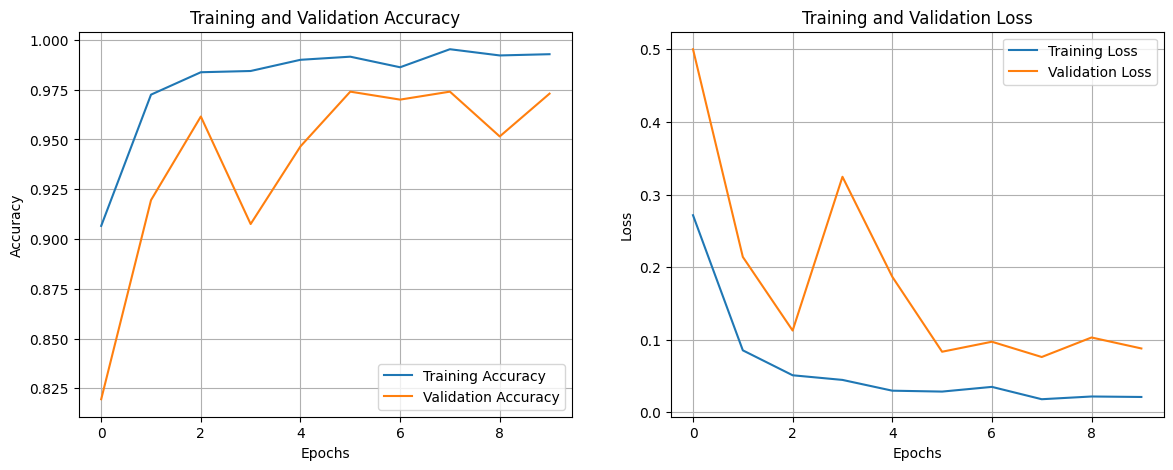

In [20]:
import matplotlib.pyplot as plt

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Training and Validation Loss')

    plt.show()

plot_training(history)

💡 Explanation:

This function visualizes training progress by plotting accuracy and loss curves.



---

🔹 Step 13: Install and Import Gradio

---



In [23]:
!pip install gradio
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image



---
🔹 Step 14: Build the Gradio Interface

---




In [24]:
model = tf.keras.models.load_model("mobilenetv2_colon_disease_detection_model.h5")

class_names = ['Normal', 'Ulcerative Colitis', 'Polyps', 'Esophagitis']

# Prediction function
def classify_image(image):
    image = image.resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)[0]
    result = {class_names[i]: float(prediction[i]) for i in range(len(class_names))}
    return result

# Gradio Interface
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=len(class_names)),
    title="Colon Disease Detection",
    description="Upload an image to classify the type of colon disease."
)

interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://072dcab2977327e7aa.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
